## Price Predictions Bayesian Neural Networks - Oliver Dobbs


### Import Packages

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from blitz.modules import BayesianLSTM
from blitz.utils import variational_estimator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque

import yfinance as yf

plt.rcParams.update({'figure.figsize':(13,10)})
plt.rcParams.update({'font.size':20})

## Input Stock Ticker or Commodity

In [2]:
ticker = "SPY" #"BTC-USD" #"AAPL" #"NFLX"

### Extract Price Information From Yahoo Finance

In [3]:
ticker_y = yf.Ticker(ticker)
df_non_stat = ticker_y.history(period="5y")

In [4]:
df_non_stat.reset_index(inplace=True)

In [5]:
series=df_non_stat.Close

In [6]:
Data_df = df_non_stat[['Date']]

### As you can see from the plot this data is not stationary

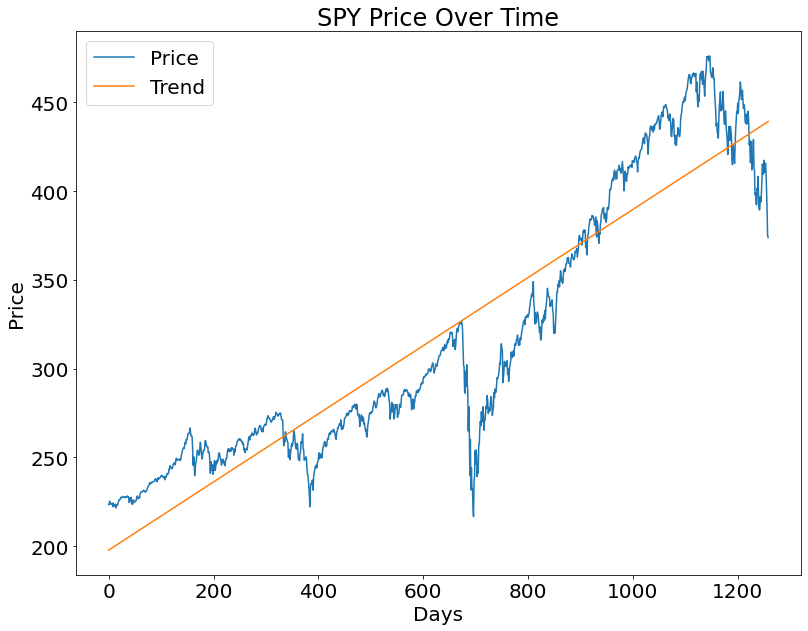

In [7]:
X = [i for i in range(0, len(series))]
X = np.reshape(X, (len(X), 1))
y = series.values
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)
plt.plot(y, label ="Price")
plt.plot(trend, label ="Trend")
plt.legend(loc="upper left")
plt.title(ticker + " Price Over Time", color="black")
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

## Make Data Stationary - Traditional

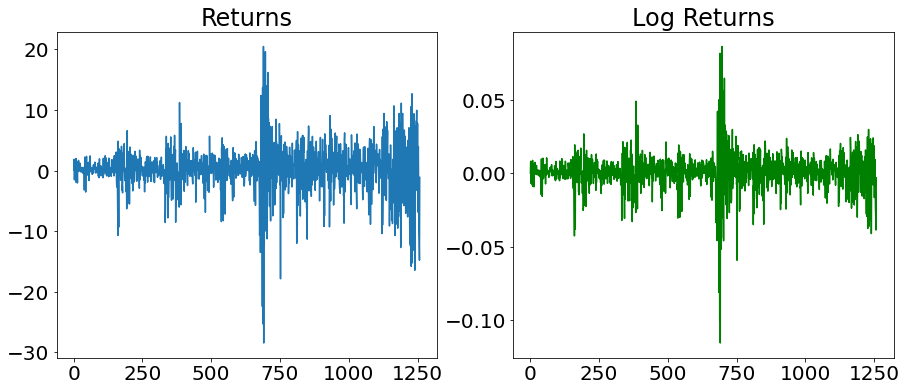

In [8]:
df_non_stat = df_non_stat[['Close']]
df_non_stat['Returns']=df_non_stat['Close']-df_non_stat['Close'].shift(1)

df_log=pd.DataFrame(np.log(df_non_stat['Close']),index=df_non_stat.index)
df_log['Log_Returns']=df_log['Close']-df_log['Close'].shift(1)
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(df_non_stat['Returns'])
plt.title('Returns')
plt.subplot(1,2,2)
plt.plot(df_log['Log_Returns'],'g-')
plt.title('Log Returns')
plt.show()

### ADF Test

In [9]:
adftest_ret=adfuller(df_non_stat['Returns'].dropna())
print('Returns ADF Statistic: %f' % adftest_ret[0])
print('Returns ADF p-value: %f' % adftest_ret[1])
adftest_lret=adfuller(df_log['Log_Returns'].dropna())
print('Log-Returns ADF Statistic: %f' % adftest_lret[0])
print('Log-Returns ADF p-value: %f' % adftest_lret[1])

Returns ADF Statistic: -10.546579
Returns ADF p-value: 0.000000
Log-Returns ADF Statistic: -10.455345
Log-Returns ADF p-value: 0.000000


## Making Data Stationary - Fractional Differencing

In [10]:
def getWeights(d,lags):
    w=[1]
    for k in range(1,lags):
        w.append(-w[-1]*((d-k+1))/k)
    w=np.array(w).reshape(-1,1) 
    return w
def plotWeights(dRange, lags, numberPlots):
    weights=pd.DataFrame(np.zeros((lags, numberPlots)))
    interval=np.linspace(dRange[0],dRange[1],numberPlots)
    for i, diff_order in enumerate(interval):
        weights[i]=getWeights(diff_order,lags)
    weights.columns = [round(x,2) for x in interval]
    fig=weights.plot(figsize=(15,6))
    plt.legend(title='Order of differencing',loc=1)
    plt.title('Lag coefficients for various orders of differencing')
    plt.xlabel('lag coefficients')
    plt.show()
def ts_differencing(series, order, lag_cutoff):
    weights=getWeights(order, lag_cutoff)
    res=0
    for k in range(lag_cutoff):
        res += weights[k]*series.shift(k).fillna(0)
    return res[lag_cutoff:]

In [11]:
plt.rcParams.update({'figure.figsize':(20,13)})
plt.rcParams.update({'font.size':15})

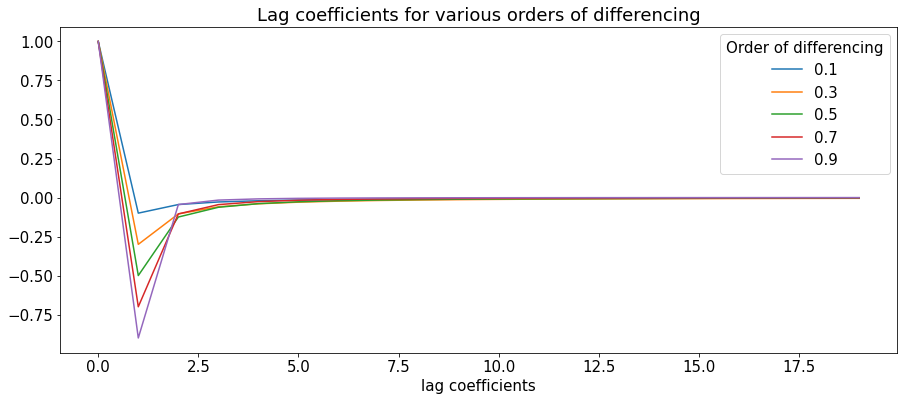

In [12]:
plotWeights([0.1,0.9],20,5)

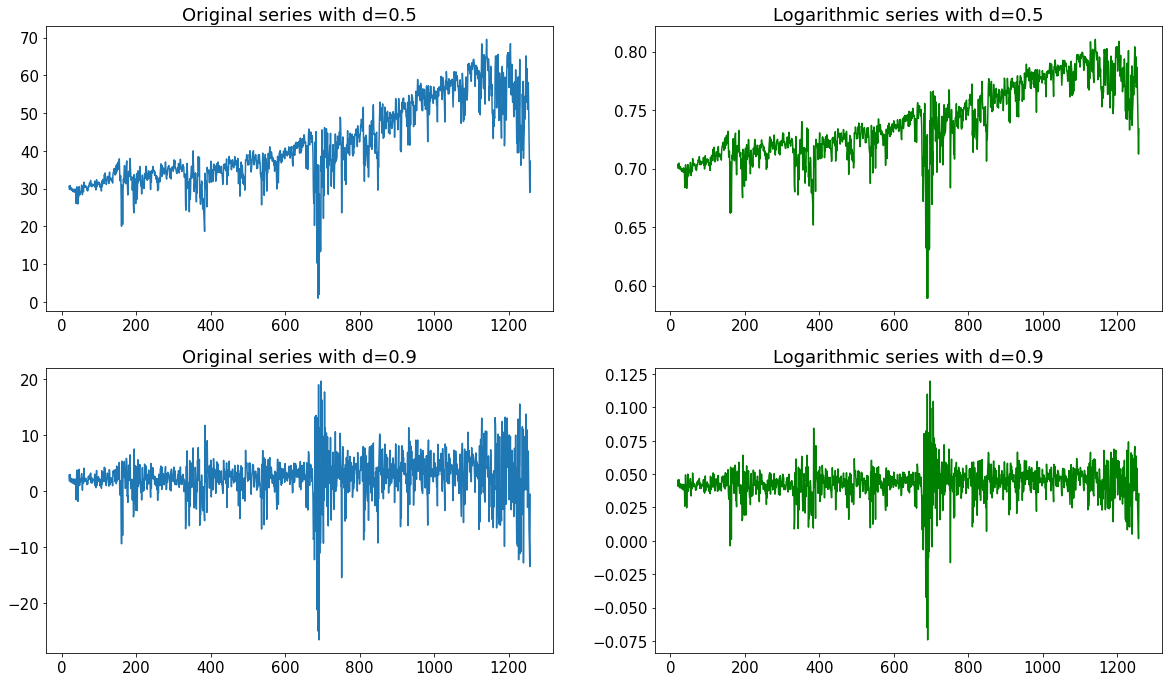

In [13]:
differences=[0.5,0.9]
fig, axs = plt.subplots(len(differences),2,figsize=(20,10))
for i in range(0,len(differences)):
    axs[i,0].plot(ts_differencing(df_non_stat['Close'],differences[i],20))
    axs[i,0].set_title('Original series with d='+str(differences[i]))
    axs[i,1].plot(ts_differencing(df_log['Close'],differences[i],20),'g-')
    axs[i,1].set_title('Logarithmic series with d='+str(differences[i]))
    plt.subplots_adjust(bottom=0.01)

In [14]:
def cutoff_find(order,cutoff,start_lags):
    val=np.inf
    lags=start_lags
    while abs(val)>cutoff:
        w=getWeights(order, lags)
        val=w[len(w)-1]
        lags+=1
    return lags

In [15]:
def ts_differencing_tau(series, order, tau):
    # return the time series resulting from (fractional) differencing
    lag_cutoff=(cutoff_find(order,tau,1)) #finding lag cutoff with tau
    weights=getWeights(order, lag_cutoff)
    res=0
    for k in range(lag_cutoff):
        res += weights[k]*series.shift(k).fillna(0)
    return res[lag_cutoff:] 

In [16]:
possible_d=np.divide(range(1,100),100)
tau=1e-4
original_adf_stat_holder=[None]*len(possible_d)
log_adf_stat_holder=[None]*len(possible_d)

for i in range(len(possible_d)):
    original_adf_stat_holder[i]=adfuller(ts_differencing_tau(df_non_stat['Close'],possible_d[i],tau))[1]
    log_adf_stat_holder[i]=adfuller(ts_differencing_tau(df_log['Close'],possible_d[i],tau))[1]


In [17]:
d = {'possible_d':possible_d,
     'ADF_original':original_adf_stat_holder,
     'ADF_log':log_adf_stat_holder}
adf_df = pd.DataFrame(d)

In [18]:
for ind in adf_df.index:
    if adf_df.ADF_original[ind] < 1e-4:
        Index = ind
        Column = 'ADF_original'
        break
    if adf_df.ADF_log[ind] < 1e-4:
        Index = ind
        Column = 'ADF_log'
        break
print(Column)
print(Index)

ADF_log
50


In [19]:
if Column == 'ADF_log':
    prices_stat = ts_differencing_tau(df_log['Log_Returns'], adf_df.possible_d[ind], 1e-4)
    
if Column == 'ADF_original':
    prices_stat = ts_differencing_tau(df_non_stat['Close'], adf_df.possible_d[ind], 1e-4)

Text(0, 0.5, 'Price_Stationary')

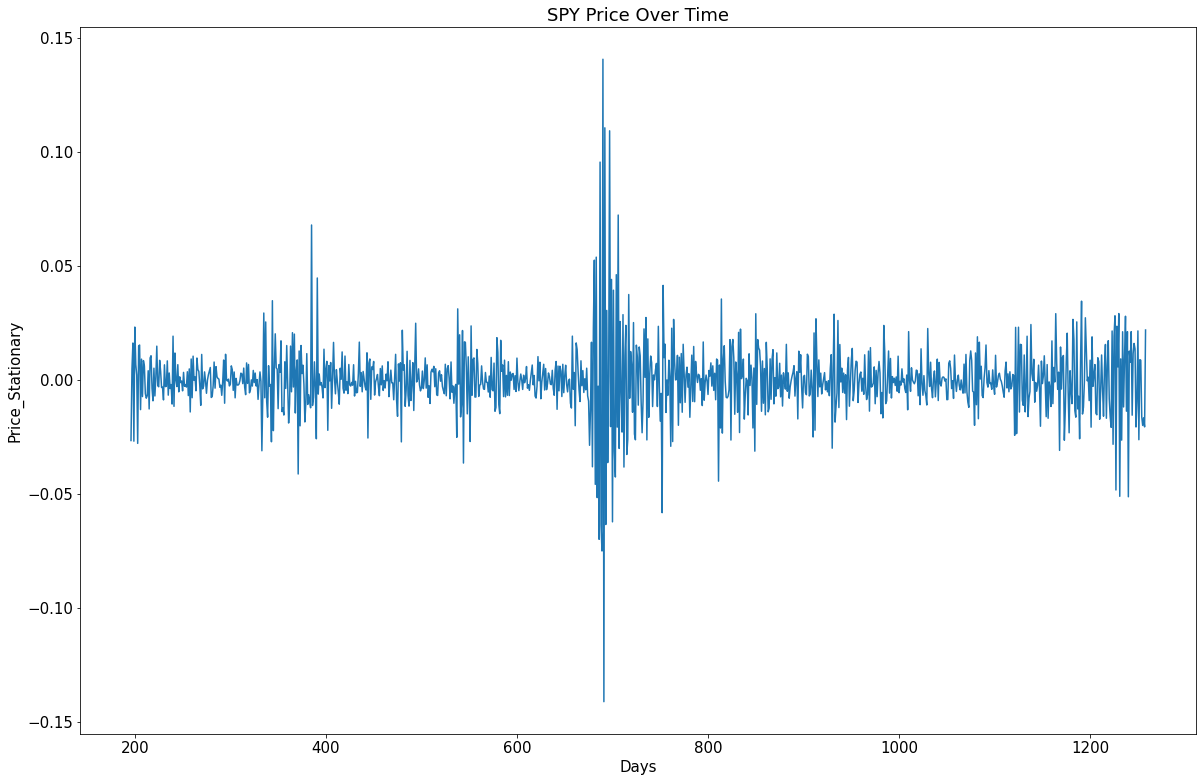

In [20]:
prices_stat.plot()
plt.title(ticker + " Price Over Time", color="black")
plt.xlabel('Days')
plt.ylabel('Price_Stationary')

In [21]:
adftest=adfuller(prices_stat.dropna())
print('Returns ADF Statistic: %f' % adftest[0])
print('Returns ADF p-value: %f' % adftest[1])

Returns ADF Statistic: -14.584556
Returns ADF p-value: 0.000000


In [22]:
d={'Close':prices_stat}

In [23]:
df = pd.DataFrame(d)
df['Date']= Data_df[196:]

### Definitions

In [24]:
window_size = 21
def create_timestamps_ds(series, 
                         timestep_size=window_size):
    time_stamps = []
    labels = []
    aux_deque = deque(maxlen=timestep_size)
    
    #starting the timestep deque
    for i in range(timestep_size):
        aux_deque.append(0)
    
    #feed the timestamps list
    for i in range(len(series)-1):
        aux_deque.append(series[i])
        time_stamps.append(list(aux_deque))
    
    #feed the labels lsit
    for i in range(len(series)-1):
        labels.append(series[i + 1])
    
    assert len(time_stamps) == len(labels), "Something went wrong"
    
    #torch-tensoring it
    features = torch.tensor(time_stamps[timestep_size:]).float()
    labels = torch.tensor(labels[timestep_size:]).float()
    
    return features, labels

In [25]:
@variational_estimator
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.lstm_1 = BayesianLSTM(1, 10, prior_sigma_1=1, prior_pi=1, posterior_rho_init=-3.0)
        self.linear = nn.Linear(10, 1)
            
    def forward(self, x):
        x_, _ = self.lstm_1(x)
        
        #gathering only the latent end-of-sequence for the linear layer
        x_ = x_[:, -1, :]
        x_ = self.linear(x_)
        return x_

In [26]:
def pred_stock_future(X_test,
                                           future_length,
                                           sample_nbr=10):
    
    #sorry for that, window_size is a global variable, and so are X_train and Xs
    global window_size
    global X_train
    global Xs
    global scaler
    
    #creating auxiliar variables for future prediction
    preds_test = []
    test_begin = X_test[0:1, :, :]
    test_deque = deque(test_begin[0,:,0].tolist(), maxlen=window_size)

    idx_pred = np.arange(len(X_train), len(Xs))
    
    #predict it and append to list
    for i in range(len(X_test)):
        #print(i)
        as_net_input = torch.tensor(test_deque).unsqueeze(0).unsqueeze(2)
        pred = [net(as_net_input).cpu().item() for i in range(sample_nbr)]
        
        
        test_deque.append(torch.tensor(pred).mean().cpu().item())
        preds_test.append(pred)
        
        if i % future_length == 0:
            #our inptus become the i index of our X_test
            #That tweak just helps us with shape issues
            test_begin = X_test[i:i+1, :, :]
            test_deque = deque(test_begin[0,:,0].tolist(), maxlen=window_size)

    #preds_test = np.array(preds_test).reshape(-1, 1)
    #preds_test_unscaled = scaler.inverse_transform(preds_test)
    
    return idx_pred, preds_test

In [27]:
def get_confidence_intervals(preds_test, ci_multiplier):
    global scaler
    
    preds_test = torch.tensor(preds_test)
    
    pred_mean = preds_test.mean(1)
    pred_std = preds_test.std(1).detach().cpu().numpy()

    pred_std = torch.tensor((pred_std))
    #print(pred_std)
    
    upper_bound = pred_mean + (pred_std * ci_multiplier)
    lower_bound = pred_mean - (pred_std * ci_multiplier)
    #gather unscaled confidence intervals

    pred_mean_final = pred_mean.unsqueeze(1).detach().cpu().numpy()
    pred_mean_unscaled = scaler.inverse_transform(pred_mean_final)

    upper_bound_unscaled = upper_bound.unsqueeze(1).detach().cpu().numpy()
    upper_bound_unscaled = scaler.inverse_transform(upper_bound_unscaled)
    
    lower_bound_unscaled = lower_bound.unsqueeze(1).detach().cpu().numpy()
    lower_bound_unscaled = scaler.inverse_transform(lower_bound_unscaled)
    
    return pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled

## Analysis on Price

In [28]:
#Create Window Size after which the prediction will start
window_size = 21

#scaling and selecting data
close_prices = df['Close']
scaler = StandardScaler()

close_prices_arr = np.array(close_prices).reshape(-1, 1)
close_prices = scaler.fit_transform(close_prices_arr)

close_prices_unscaled = df['Close']

In [29]:
Xs, ys = create_timestamps_ds(close_prices)
X_train, X_test, y_train, y_test = train_test_split(Xs,
                                                    ys,
                                                    test_size=.25,
                                                    random_state=42,
                                                    shuffle=False)



ds = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True)

net = NN()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

/var/folders/w5/d0_t8_nn0hl7thn0bzzlyk000000gn/T/ipykernel_34422/1172854888.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  features = torch.tensor(time_stamps[timestep_size:]).float()


In [30]:
iteration = 0
for epoch in range(10):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        loss = net.sample_elbo(inputs=datapoints,
                               labels=labels,
                               criterion=criterion,
                               sample_nbr=3,
                               complexity_cost_weight=1/X_train.shape[0])
        loss.backward()
        optimizer.step()
        
        iteration += 1
        if iteration%250==0:
            preds_test = net(X_test)[:,0].unsqueeze(1)
            loss_test = criterion(preds_test, y_test)
            print("Iteration: {} Val-loss: {:.4f}".format(str(iteration), loss_test))

Iteration: 250 Val-loss: 0.6521
Iteration: 500 Val-loss: 0.5924
Iteration: 750 Val-loss: 0.5807


In [31]:
#pred_unscaled
original = close_prices_unscaled[1:][window_size:]

In [32]:
df_pred = pd.DataFrame(original)
df_pred["Date"] = df.Date
df["Date"] = pd.to_datetime(df_pred["Date"])
df_pred = df_pred.reset_index()
#df_pred = df_pred.set_index('Date')

In [33]:
future_length=7
sample_nbr=4
ci_multiplier=5
idx_pred, preds_test = pred_stock_future(X_test, future_length, sample_nbr)
pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled = get_confidence_intervals(preds_test,
                                                                                          ci_multiplier)

In [34]:
c=len(upper_bound_unscaled)

### Calculate the proportion of predictions in the confidence interval

In [35]:
y = np.array(df.Close[-c:]).reshape(-1, 1)
under_upper = upper_bound_unscaled > y
over_lower = lower_bound_unscaled < y
total = (under_upper == over_lower)
price_acc = np.mean(total)
print("{} of test price is in our confidence interval".format(round(price_acc,2)))

0.48 of test price is in our confidence interval


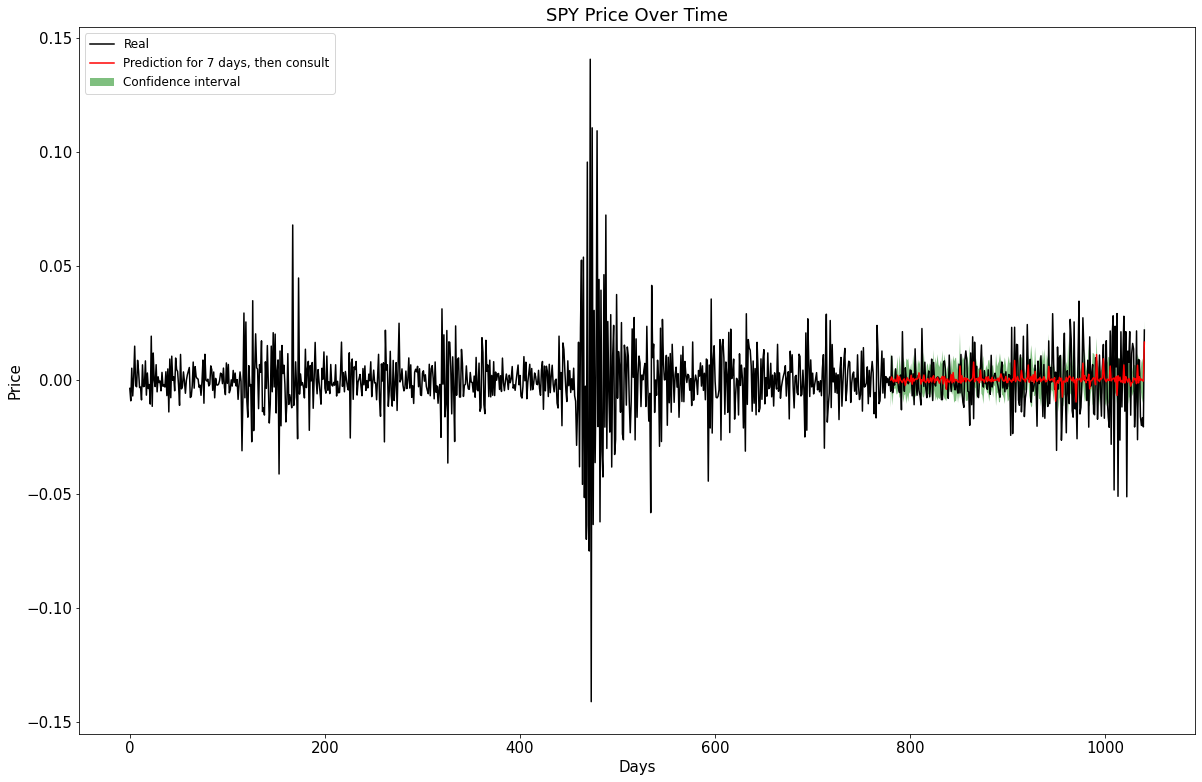

In [36]:
plt.title(ticker + " Price Over Time", color="black")

plt.plot(df_pred.index,
         df_pred.Close,
         color='black',
         label="Real")

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} days, then consult".format(future_length),
         color="red")

plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.5)

plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc="upper left",prop={'size': 12})

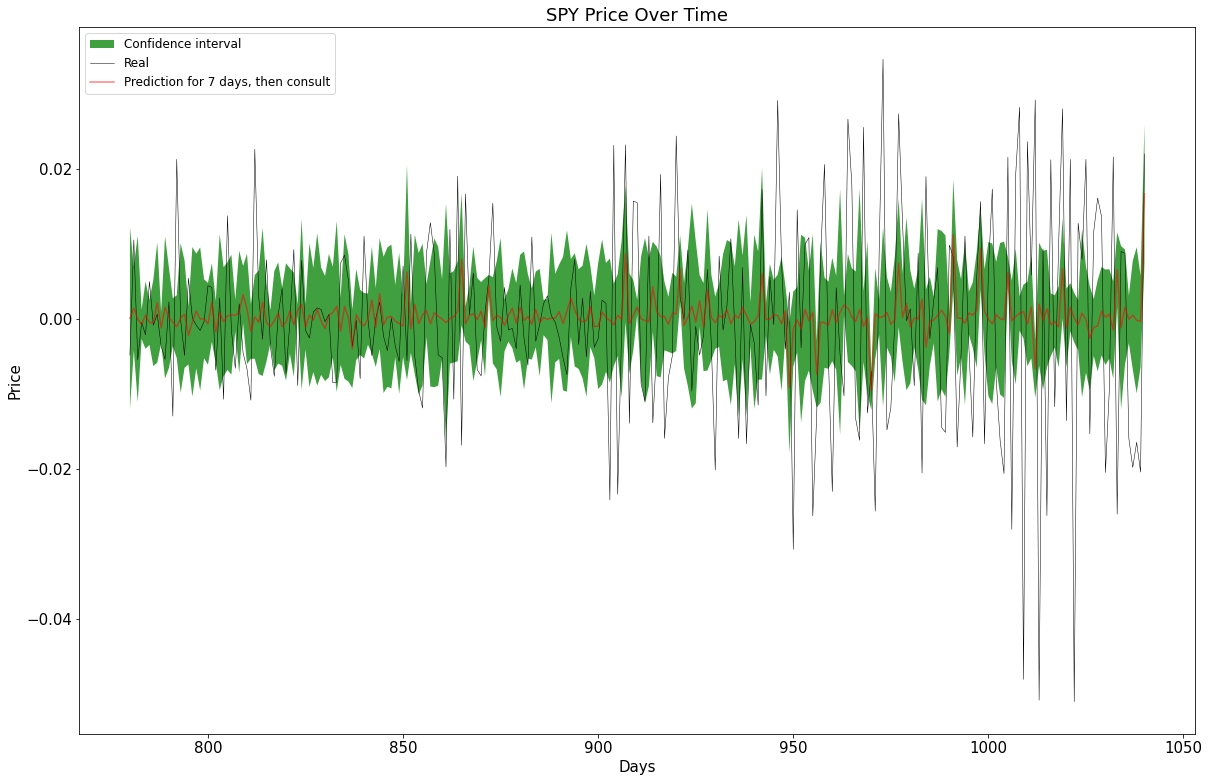

In [37]:
plt.title(ticker + " Price Over Time", color="black")


plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.75)

plt.plot(idx_pred,
         df_pred.Close[-len(pred_mean_unscaled):],
         label="Real",
         alpha=1,
         color='black',
         linewidth=0.5)

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} days, then consult".format(future_length),
         color="red",
         alpha=0.5)

plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc="upper left",prop={'size': 12})

## References

I would like to thank Piero Esposito for creating the Blitz module. I would also like to thank him for his conversations on this project and his base code for conducting Bayesian Learning for Stock Market Predictions.

@misc{esposito2020blitzbdl,
author = {Piero Esposito},
    title = {BLiTZ - Bayesian Layers in Torch Zoo (a Bayesian Deep Learing library for Torch)},
    year = {2020},
    publisher = {GitHub},
    journal = {GitHub repository},
    howpublished = {\url{https://github.com/piEsposito/blitz-bayesian-deep-learning/}},
}